## important notes
- we should pick a single material to use as our dome

## recent changelog
- solar constant derivation added 

uncomment and run this cells if you get errors 

In [302]:
# pip install scipy.optimize
# pip install matplotlib 
# pip install numpy

In [303]:
import numpy as np 
import matplotlib.pyplot as plot 
from scipy.optimize import fsolve

### thermals stuff

#### put all constants in here

In [304]:
# used for stefan-boltzman calculations
SIGMA = 5.67e-8 # W / m^2 / k
EPSILON = 1.0 # we are modeling as a "worst case" blackbody material
T_INF = 3 # K 

# used for sun heating stuff
SOLAR_INTENSITY = 1320 # W / m^2
SOLAR_TEMPERATURE = 5778
SOLAR_EPSILON = 0.99

# general properties
CP_AIR = 1004 # J / kg / k
AIR_DENSITY = 1.29 # kg / m^3

# moon base params
REGOLITH_CONDUCTIVITY = 0.75 # found on the internet 
REGOLITH_DENSITY = 1300 # kg / m^3
CP_REGOLITH = 1400 # J / kg / k
WALL_THICKNESS_RATIO = 0.4 # fraction of sphere radius that is wall 


In [305]:
def point_source_heating(absorptivity, area, intensity):
    return absorptivity * area * intensity

def stefan_boltzmann(area, surface_temperature):
    return EPSILON * SIGMA * area * surface_temperature**4

def celsius_to_kelvin(temp):
    return temp + 273.15

class ThermalData:
    def __init__(self, radius, thickness, conductivity):
        self.radius = radius
        self.thickness = thickness
        self.conductivity = conductivity
        self.times = []
        self.internal_temperatures = []
        self.surface_temperatures = []
        self.q_dots = []

### general sphere stuff

In [306]:
class Wall:
    def __init__(self, thickness, conductivity, absorptivity):
        self.thickness = thickness
        self.conductivity = conductivity
        self.absorptivity = absorptivity

class Sphere:
    def __init__(self, radius, wall):
        self.radius = radius
        self.wall = wall
        self.internal_temperature = celsius_to_kelvin(22) # placeholder for now
        self.surface_temperature = 5 # arbitrary starting value close to the temperature of space 
        self.light_intensity = SOLAR_INTENSITY

        self.reup_temperatures(0)
        return None

    def volume(self):
        return 4 / 3 * np.pi * self.radius**3
    
    def volume_air(self):
        return 4 / 3 * np.pi * (self.radius - self.wall.thickness)**3
    
    def volume_wall(self):
        return self.volume() - self.volume_air()
    
    def surface_area(self):
        return 4 * np.pi * self.radius**2

    def projected_area(self):
        return np.pi * self.radius**2

    def mass_air(self):
        return self.volume_air() * AIR_DENSITY
    
    def mass_wall(self):
        return self.volume_wall() * REGOLITH_DENSITY

    def reup_temperatures(self, delta_time):
        self.__reup_internal_temperature(delta_time)
        self.__reup_surface_temperature()
    
    def total_heat_transfer(self):
        heating = point_source_heating(self.wall.absorptivity, self.projected_area(), self.light_intensity)
        cooling = -stefan_boltzmann(self.surface_area(), self.surface_temperature)
        return heating + cooling
    
    def __reup_surface_temperature(self):
        def energy_balance(surface_temperature):
            q_cond = (self.wall.conductivity / self.wall.thickness) * (self.internal_temperature - surface_temperature) * self.surface_area()
            q_rad = stefan_boltzmann(self.surface_area(), surface_temperature)
            return q_cond - q_rad

        temperature_guess = (self.internal_temperature + T_INF) / 2 # start by guessing the average temperature
        solution = fsolve(energy_balance, temperature_guess) # use fsolve to find what temperature actually works
        self.surface_temperature = solution[0]

    def __reup_internal_temperature(self, delta_time):
        q_net = self.total_heat_transfer()
        thermal_storage = self.mass_air() * CP_AIR + self.mass_wall() * CP_REGOLITH
        delta_temp = (q_net * delta_time) / thermal_storage # this is obv just using 1st order integration, we can change this to RK4 later
        self.internal_temperature += delta_temp


### this is acting as just a 'hello world' cell, make sure this runs with no errors

In [307]:
# hello world 
sphere = Sphere(1, Wall(0.5, 1, 1))
assert sphere.surface_area() == 4 * np.pi, "make sure this runs"
print("sphere area:", sphere.surface_area())
print("calculated surface temperature:", sphere.surface_temperature)

sphere area: 12.566370614359172
calculated surface temperature: 223.90111383073173


### first actual calculations for a dome

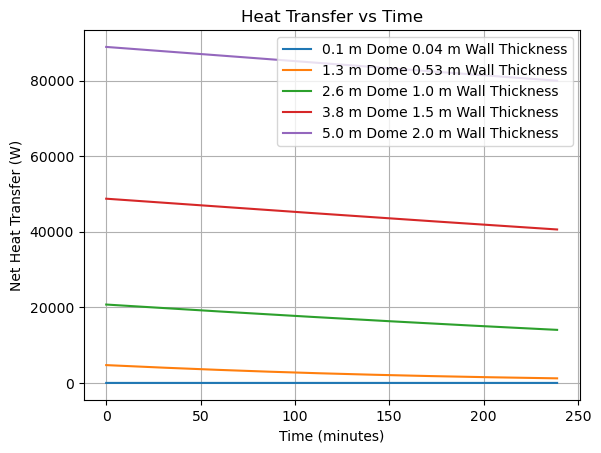

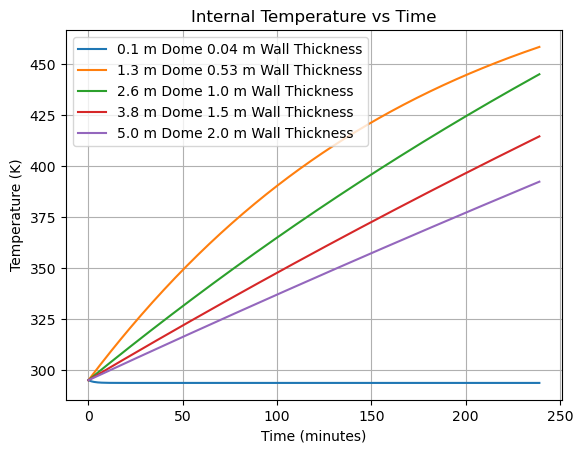

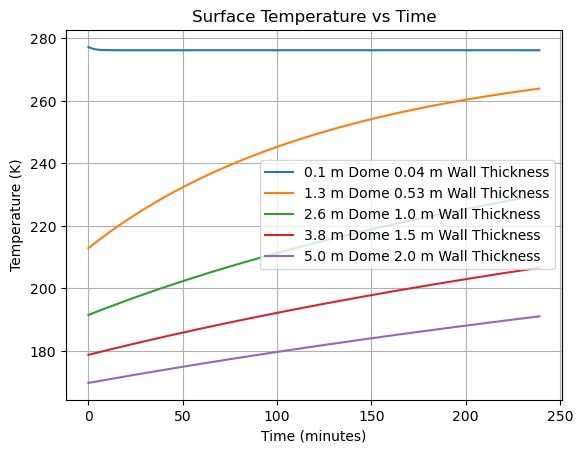

In [308]:
datasets = []

radii = np.linspace(0.1, 5.0, 5)
conductivity = REGOLITH_CONDUCTIVITY
dt = 60 * 60
duration = 60 * 60 * 24 * 10 # sec -> min -> day -> 180 days 

for radius in radii:
    thickness = radius * WALL_THICKNESS_RATIO
    wall = Wall(thickness, conductivity, EPSILON)
    sphere = Sphere(radius, wall)
    data = ThermalData(radius, thickness, conductivity)

    for t in range(0, duration, dt):
        data.times.append(t / dt)
        data.internal_temperatures.append(sphere.internal_temperature)
        data.surface_temperatures.append(sphere.surface_temperature)
        data.q_dots.append(sphere.total_heat_transfer())
        sphere.reup_temperatures(dt)

    datasets.append(data)

plot.figure()
for data in datasets:
    plot.plot(data.times, data.q_dots, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Heat Transfer vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Net Heat Transfer (W)")
plot.grid(True)
plot.legend()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Internal Temperature vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.surface_temperatures, label = f'{data.radius:0.2} m Dome {data.thickness:0.2} m Wall Thickness')
plot.title("Surface Temperature vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()

### 6 month (lunar days basically) tracking to see more obvious heat is losing during the lunar night

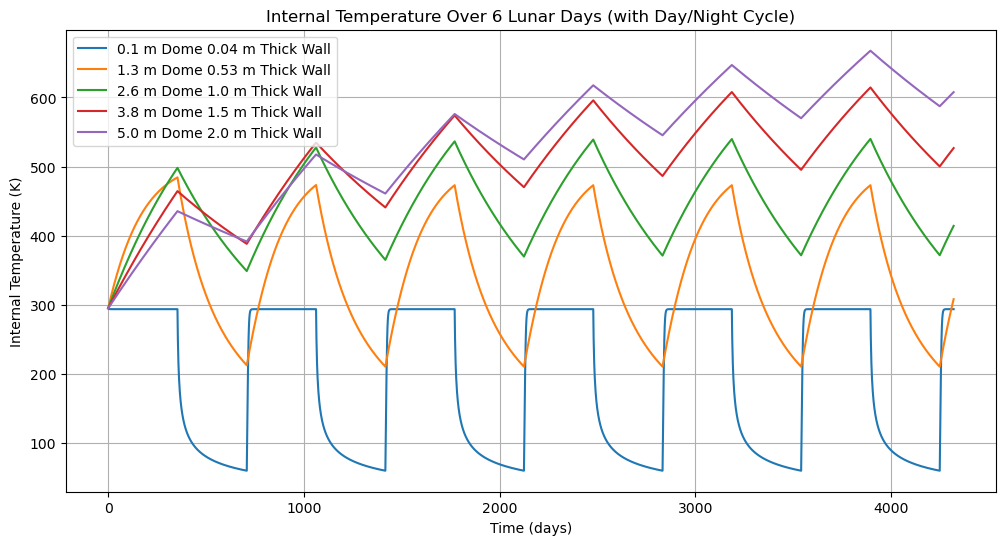

In [309]:
duration = 60 * 60 * 24 * 180 # sec -> min -> day -> 180 days 
dt = 60 * 60 # simultion in first order integration for 10 minutes
lunar_day = 60 * 60 * 24 * 29.5
sunlight_hours = 0.5

datasets = []
radii = np.linspace(0.1, 5, 5)
conductivity = REGOLITH_CONDUCTIVITY

for radius in radii:
    thickness = radius * WALL_THICKNESS_RATIO
    wall = Wall(thickness, conductivity, EPSILON)
    sphere = Sphere(radius, wall)
    data = ThermalData(radius, thickness, conductivity)

    for t in range(0, duration, dt):
        time_in_cycle = t % lunar_day
        is_day: bool = time_in_cycle < (lunar_day * sunlight_hours)
        sphere.light_intensity = SOLAR_INTENSITY if is_day else 0 # basically turns the sun off if it is night

        data.times.append(t / (dt))
        data.internal_temperatures.append(sphere.internal_temperature)
        data.surface_temperatures.append(sphere.surface_temperature)
        data.q_dots.append(sphere.total_heat_transfer())
        sphere.reup_temperatures(dt)

    datasets.append(data)

plot.figure(figsize=(12, 6))
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label=f'{data.radius:0.2} m Dome {data.thickness:0.2} m Thick Wall')
plot.title("Internal Temperature Over 6 Lunar Days (with Day/Night Cycle)")
plot.xlabel("Time (days)")
plot.ylabel("Internal Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()

### energy requirements to maintain a livable temperature

### approximation of the solar constant derivation

In [310]:
solar_radius = 696_000_000 # m
astro_unit = 150_000_000_000 # m
solar_epsilon = SOLAR_EPSILON
solar_temperature = SOLAR_TEMPERATURE
sun = Sphere(solar_radius, Wall(1, 1, solar_epsilon))
earth_shell = Sphere(astro_unit, Wall(1, 1, EPSILON))

solar_radiation = stefan_boltzmann(sun.surface_area(), solar_temperature)

solar_constant = solar_radiation / earth_shell.surface_area()

# amazing
print(f'solar constant: {solar_constant}')
assert 1200 < solar_constant and solar_constant < 1500

solar constant: 1360.5959379253902


#### just using as a calculator

In [311]:
radius = 5
sphere = Sphere(radius, Wall(1, 1, 1))
sphere.volume()

523.5987755982989

In [312]:
radius = 2
sphere = Sphere(radius, Wall(0, 1, 1))
sphere.volume() * 16

ZeroDivisionError: division by zero